In [ ]:
# pip install osmnx
# pip install pqdm
# pip install alphashape
# pip install geopandas fsspec s3fs

In [1]:
import os
import sagemaker
import boto3

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
import osmnx as ox
import shapely
from shapely.geometry import Point
import networkx as nx
from pqdm.processes import pqdm
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

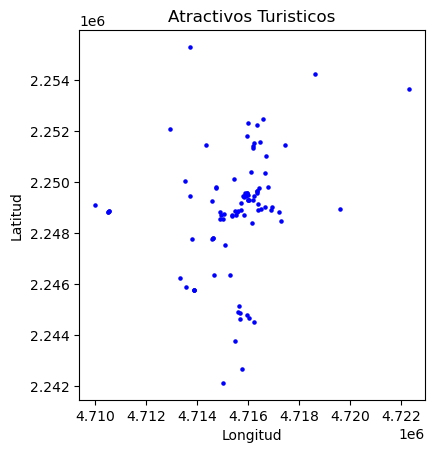

In [3]:
bucket_name = 'bucket-lcid-2'
file_key = "shp_atractivos_turisticos/atractivos_turisticos.shp"

s3_path = f's3://{bucket_name}/{file_key}'

gdf = gpd.read_file(s3_path)

gdf.plot(marker='o', color='blue', markersize=5)
plt.title("Atractivos Turisticos")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

In [ ]:
# place = "Medellín, Colombia"
# network_type = "walk"
# G = ox.graph_from_place(place, network_type=network_type)
# G = ox.project_graph(G)

In [4]:
# Define un polígono utilizando coordenadas de latitud y longitud
polygon = shapely.geometry.Polygon([
    (-75.65779, 6.32383),
    (-75.47137, 6.32383),
    (-75.47137, 6.16689),
    (-75.65779, 6.16689),
    (-75.65779, 6.32383)
])
G = ox.graph_from_polygon(polygon, network_type="walk")
G_UTM = ox.project_graph(G)

In [5]:
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")

<Axes: >

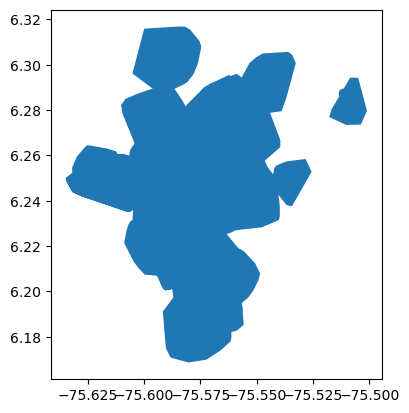

In [6]:
trip_times = [10, 20, 30]  # en minutos
travel_speed = 4.5  # velocidad de caminata en km/h
meters_per_minute = travel_speed * 1000 / 60  # km por hora a m por minuto

# Añadir un atributo de tiempo en minutos necesario para recorrer cada arista
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

def calculate_isochrones_for_gdf(gdf, G, trip_times=trip_times):
    results = []
    
    # Iterar sobre cada punto en el GeoDataFrame
    for idx, row in gdf.iterrows():
        lon, lat = row.geometry.x, row.geometry.y
        codigo = row['cod'] if 'cod' in gdf.columns else None
        
        # Crear un GeoDataFrame para el punto actual
        point_gdf = gpd.GeoDataFrame([{'geometry': Point(lon, lat)}], crs="EPSG:4326")
        point_gdf_utm = point_gdf.to_crs(G.graph['crs'])

        # Obtener las coordenadas transformadas
        x, y = point_gdf_utm.geometry.x[0], point_gdf_utm.geometry.y[0]
        
        # Encontrar el nodo más cercano
        center_node = ox.distance.nearest_nodes(G, x, y)

        # Calcular isocronas para cada tiempo especificado
        for trip_time in sorted(trip_times, reverse=True):
            subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
            
            # Crear un polígono que cubra el área accesible en este tiempo
            node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
            bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
            
            # Guardar el resultado
            results.append({'geometry': bounding_poly, 'trip_time': trip_time, 'cod': codigo})
    
    # Convertir los resultados en un GeoDataFrame
    result_gdf = gpd.GeoDataFrame(results, crs=G.graph['crs'])
    return result_gdf

# Ejemplo de uso
# Supongamos que `gdf_points` es tu GeoDataFrame con múltiples puntos
# y `G` es tu grafo de OSM

result_gdf = calculate_isochrones_for_gdf(gdf, G)
result_gdf.plot()

In [ ]:
# Guardar el GeoDataFrame resultante en un archivo GeoPackage
output_path = "isochrones_atractivos_turisticos.gpkg"
result_gdf.to_file(output_path, layer='isochrones_atractivos_turisticos', driver="GPKG")

In [16]:
import s3fs

local_gpkg_path = "isochrones_atractivos_turisticos.gpkg"
bucket_name = 'bucket-lcid-2'
file_key = "shp_atractivos_turisticos/isochrones_atractivos_turisticos.gpkg"
s3_path = f's3://{bucket_name}/{file_key}'

fs = s3fs.S3FileSystem()
with fs.open(s3_path, 'wb') as f:  # Abrir en modo binario de escritura en S3
    with open(local_gpkg_path, 'rb') as local_file:  # Abrir el archivo local en modo binario de lectura
        f.write(local_file.read())

print("Archivo GeoPackage almacenado exitosamente en S3.")



Archivo GeoPackage almacenado exitosamente en S3.


# Isócronas de alojamientos

In [3]:
bucket_name = 'bucket-lcid-2'
file_key = "shp_establecimientos_de_indus/establecimientos_de_indus.shp"

s3_path = f's3://{bucket_name}/{file_key}'
gdf_tot = gpd.read_file(s3_path)

In [4]:
gdf_tot.head()

,id_contrat,nombre_est,corregimie,codigociiu,grupo_acti,comuna,nombre_com,codigo_bar,nombre_bar,x_magnamed,y_magnamed,longitud,latitud,geometry
0,00000000000001808816,NO POSEE ESTABLECIMIENTOS,None,6201,03,14,El Poblado,1403,Villa Carlota,834294.0371,1.179867e+06,-75.574685,6.220620,POINT (4715197.430 2246060.631)
1,00000000000001808810,NO POSEE ESTABLECIMIENTOS,None,5619,03,16,Belen,1603,Belen,831801.1247,1.181132e+06,-75.597206,6.232055,POINT (4712710.751 2247337.613)
2,00000000000001808812,CONTINENTAL TECHNOLOGY AR,None,4741,02,10,La Candelaria,1019,La Candelaria,835211.8729,1.183367e+06,-6.222663,75.566394,POINT (4716132.256 2249556.478)
3,00000000000001808826,NO POSEE ESTABLECIMIENTOS,None,8299,03,16,Belen,1609,La Hondonada,831361.2423,1.177903e+06,-75.601178,6.202866,POINT (4712255.215 2244111.232)
4,00000000000001808817,NO POSEE ESTABLECIMIENTOS,None,2023,01,08,Villa Hermosa,0806,Llanaditas,837901.2523,1.183549e+06,-75.542097,6.253908,POINT (4718822.359 2249724.949)


In [17]:
# gdf = gdf_tot[gdf_tot['codigociiu'].notna() & gdf_tot['codigociiu'].str.startswith('55')]
gdf = gdf_tot[gdf_tot['codigociiu'].notna() & gdf_tot['codigociiu'].str.match(r'^(6[9]|7[0-5])')]
gdf.head()

,id_contrat,nombre_est,corregimie,codigociiu,grupo_acti,comuna,nombre_com,codigo_bar,nombre_bar,x_magnamed,y_magnamed,longitud,latitud,geometry
6,00000000000001808856,NO POSEE ESTABLECIMIENTOS,None,7410,03,14,El Poblado,1418,El Poblado,835282.4702,1.178761e+06,-75.565756,6.210622,POINT (4716180.452 2244949.924)
26,00000000000001808442,NO POSEE ESTABLECIMIENTOS,None,7020,03,14,El Poblado,1413,El Diamante No. 2,834680.9336,1.175743e+06,-75.571190,6.183340,POINT (4715564.353 2241935.265)
54,00000000000001808866,NO POSEE ESTABLECIMIENTOS,None,6910,03,11,Laureles Estadio,1113,El Estadio,831779.6800,1.184250e+06,-75.597402,6.260246,POINT (4712704.505 2250455.928)
74,00000000000001808786,NO POSEE ESTABLECIMIENTOS,None,7010,03,14,El Poblado,1413,El Diamante No. 2,834956.8049,1.175493e+06,-75.568698,6.181081,POINT (4715839.006 2241684.037)
89,00000000000001808822,NO POSEE ESTABLECIMIENTOS,None,7310,03,12,La America,1204,La America,831071.8534,1.183120e+06,-75.603796,6.250032,POINT (4711991.181 2249329.728)


In [18]:
polygon = shapely.geometry.Polygon([
    (-75.65779, 6.32383),
    (-75.47137, 6.32383),
    (-75.47137, 6.16689),
    (-75.65779, 6.16689),
    (-75.65779, 6.32383)
])
G = ox.graph_from_polygon(polygon, network_type="walk")
G_UTM = ox.project_graph(G)

In [19]:
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")

<Axes: >

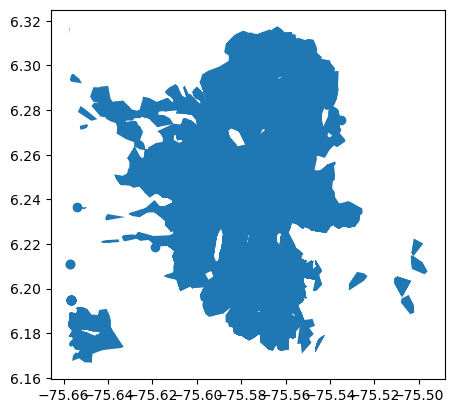

In [20]:
trip_times = [5,10]  # en minutos
travel_speed = 4.5  # velocidad de caminata en km/h
meters_per_minute = travel_speed * 1000 / 60  # km por hora a m por minuto

# Añadir un atributo de tiempo en minutos necesario para recorrer cada arista
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

def calculate_isochrones_for_gdf(gdf, G, trip_times=trip_times):
    results = []
    
    # Iterar sobre cada punto en el GeoDataFrame
    for idx, row in gdf.iterrows():
        lon, lat = row.geometry.x, row.geometry.y
        codigo = row['cod'] if 'cod' in gdf.columns else None
        
        # Crear un GeoDataFrame para el punto actual
        point_gdf = gpd.GeoDataFrame([{'geometry': Point(lon, lat)}], crs="EPSG:4326")
        point_gdf_utm = point_gdf.to_crs(G.graph['crs'])

        # Obtener las coordenadas transformadas
        x, y = point_gdf_utm.geometry.x[0], point_gdf_utm.geometry.y[0]
        
        # Encontrar el nodo más cercano
        center_node = ox.distance.nearest_nodes(G, x, y)

        # Calcular isocronas para cada tiempo especificado
        for trip_time in sorted(trip_times, reverse=True):
            subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
            
            # Crear un polígono que cubra el área accesible en este tiempo
            node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
            bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
            
            # Guardar el resultado
            results.append({'geometry': bounding_poly, 'trip_time': trip_time, 'cod': codigo})
    
    # Convertir los resultados en un GeoDataFrame
    result_gdf = gpd.GeoDataFrame(results, crs=G.graph['crs'])
    return result_gdf

# Ejemplo de uso
# Supongamos que `gdf_points` es tu GeoDataFrame con múltiples puntos
# y `G` es tu grafo de OSM

result_gdf = calculate_isochrones_for_gdf(gdf, G)
result_gdf.plot()

In [21]:
output_path = "isochrones_establecimientos_de_indus_centros.gpkg"
result_gdf.to_file(output_path, layer='isochrones_establecimientos_de_indus_centros', driver="GPKG")

In [22]:
import s3fs

local_gpkg_path = "isochrones_establecimientos_de_indus_centros.gpkg"
bucket_name = 'bucket-lcid-2'
file_key = "shp_establecimientos_de_indus/isochrones_establecimientos_de_indus_centros.gpkg"
s3_path = f's3://{bucket_name}/{file_key}'

fs = s3fs.S3FileSystem()
with fs.open(s3_path, 'wb') as f:  # Abrir en modo binario de escritura en S3
    with open(local_gpkg_path, 'rb') as local_file:  # Abrir el archivo local en modo binario de lectura
        f.write(local_file.read())

print("Archivo GeoPackage almacenado exitosamente en S3.")

Archivo GeoPackage almacenado exitosamente en S3.


### Leer archivos y descargar

In [35]:
bucket_name = 'bucket-lcid-2'
nameFile= "parada_de_transporte_publ"
fold = "CruceIsocronas/ServiciosTransporte/Dataset_puntos/"
file_key = fold + nameFile+".shp"

s3_path = f's3://{bucket_name}/{file_key}'

gdf = gpd.read_file(s3_path)
gdf.to_file(nameFile+".gpkg", layer=nameFile, driver="GPKG")